# Modeling Explainability (Assignment 9)

## Student: Rodolfo Lerma

In this assignment, you will use `LIME` library to perform local explanations using surrogate modelsto explain the results of Random Forest Classifier models.

In [1]:
# !pip install lime
# pip install plotly

In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import warnings
np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 7]

# warnings.filterwarnings('ignore')
import lime
import lime.lime_tabular

In [3]:
df_data = pd.read_csv('./music.xls')
df_data.head()

artist.familiarity  artist.hotttnesss           artist.id  artist.latitude  \
0            0.581794           0.401998  ARD7TVE1187B99BFB1          0.00000   
1            0.630630           0.417500  ARMJAGH1187FB546F3         35.14968   
2            0.487357           0.343428  ARKRRTF1187B9984DA          0.00000   
3            0.630382           0.454231  AR7G5I41187FB4CE6C          0.00000   
4            0.651046           0.401724  ARXR32B1187FB57099          0.00000   

   artist.location  artist.longitude       artist.name  artist.similar  \
0                0           0.00000            Casual             0.0   
1                0         -90.04892      The Box Tops             0.0   
2                0           0.00000  Sonora Santanera             0.0   
3                0           0.00000          Adam Ant             0.0   
4                0           0.00000               Gob             0.0   

     artist.terms  artist.terms_freq  ...  song.mode  song.mode_confidence  \
0         hip hop           1.000000  ...          0                 0.636   
1  blue-eyed soul           1.000000  ...          0                 0.430   
2           salsa           1.000000  ...          1                 0.565   
3        pop rock           0.988584  ...          1                 0.749   
4        pop punk           0.887288  ...          1                 0.371   

   song.start_of_fade_out  song.tatums_confidence  song.tatums_start  \
0                 218.932                   0.779            0.28519   
1                 137.915                   0.969            0.20627   
2                 172.304                   0.482            0.42132   
3                 217.124                   0.601            0.56254   
4                 198.699                   1.000            0.13576   

   song.tempo  song.time_signature  song.time_signature_confidence  \
0      92.198                  4.0                           0.778   
1     121.274                  4.0                           0.384   
2     100.070                  1.0                           0.000   
3     119.293                  4.0                           0.000   
4     129.738                  4.0                           0.562   

   song.title  song.year  
0           0          0  
1           0       1969  
2           0          0  
3           0       1982  
4           0       2007  

[5 rows x 35 columns]

In [4]:
df_data.shape

(10000, 35)

The dataframe contains 35 features/columns and 10,000 datapoints/rows.

In [5]:
df_data.dtypes

artist.familiarity                float64
artist.hotttnesss                 float64
artist.id                          object
artist.latitude                   float64
artist.location                     int64
artist.longitude                  float64
artist.name                        object
artist.similar                    float64
artist.terms                       object
artist.terms_freq                 float64
release.id                          int64
release.name                        int64
song.artist_mbtags                float64
song.artist_mbtags_count          float64
song.bars_confidence              float64
song.bars_start                   float64
song.beats_confidence             float64
song.beats_start                  float64
song.duration                     float64
song.end_of_fade_in               float64
song.hotttnesss                   float64
song.id                            object
song.key                          float64
song.key_confidence               

Apart from `artist.id` & `song.id` all the other columns are either *float64* or *int64*.

In [6]:
df_data.isnull().sum()

artist.familiarity                0
artist.hotttnesss                 0
artist.id                         0
artist.latitude                   0
artist.location                   0
artist.longitude                  0
artist.name                       0
artist.similar                    0
artist.terms                      5
artist.terms_freq                 0
release.id                        0
release.name                      0
song.artist_mbtags                0
song.artist_mbtags_count          0
song.bars_confidence              0
song.bars_start                   0
song.beats_confidence             0
song.beats_start                  0
song.duration                     0
song.end_of_fade_in               0
song.hotttnesss                   0
song.id                           0
song.key                          0
song.key_confidence               0
song.loudness                     0
song.mode                         0
song.mode_confidence              0
song.start_of_fade_out      

### Question 1.1: Create the target of popular artists where artist familiarity is greater than 0.8 and artist hotttness is greater than 0.6.

In [7]:
df_data['class'] = np.where((df_data['artist.familiarity'] > 0.8) & (df_data['artist.hotttnesss'] > 0.6), 1, 0)

In [8]:
#Use Grouby on class and count artist.id
artists = df_data.groupby(['class']).count()['artist.id']
artists

class
0    9605
1     395
Name: artist.id, dtype: int64

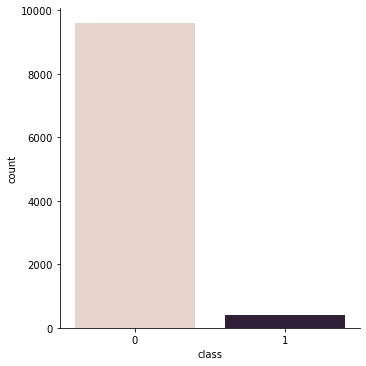

In [9]:
import seaborn as sns
sns.catplot(x="class", kind="count", palette="ch:.1", data=df_data)

Looking at the distribution of the `class` column, we can see there is a class imbalance present. For this reason I will test 2 models, one with the class imbalance present and another without.

In [10]:
def hist_plot(df,a):
    df[a].hist(figsize = (5,3))
    plt.xlabel(a, fontsize = 15)
    plt.ylabel('Frequency',fontsize = 15)
    plt.tick_params(axis="x", labelsize=10)
    plt.tick_params(axis="y", labelsize=10)
    plt.grid(True)
    plt.show()

In [11]:
vars_keep = ['song.bars_confidence', 
             'song.bars_start', 
             'song.beats_confidence', 
             'song.beats_start', 
             'song.duration', 
             'song.end_of_fade_in', 
             'song.hotttnesss', 
             'song.key_confidence', 
             'song.loudness', 
             'song.mode', 
             'song.mode_confidence', 
             'song.start_of_fade_out', 
             'song.tatums_confidence', 
             'song.tatums_start', 
             'song.tempo', 
             'song.time_signature', 
             'song.time_signature_confidence']

In [12]:
df_data[vars_keep].dtypes

song.bars_confidence              float64
song.bars_start                   float64
song.beats_confidence             float64
song.beats_start                  float64
song.duration                     float64
song.end_of_fade_in               float64
song.hotttnesss                   float64
song.key_confidence               float64
song.loudness                     float64
song.mode                           int64
song.mode_confidence              float64
song.start_of_fade_out            float64
song.tatums_confidence            float64
song.tatums_start                 float64
song.tempo                        float64
song.time_signature               float64
song.time_signature_confidence    float64
dtype: object

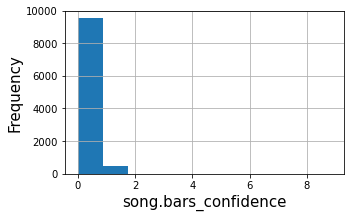

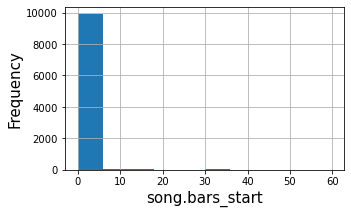

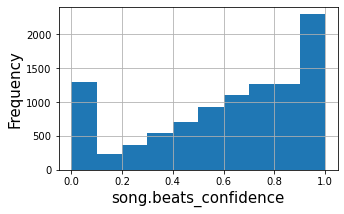

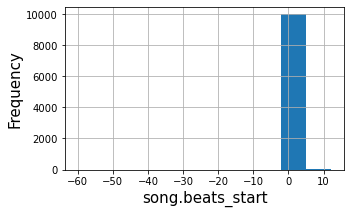

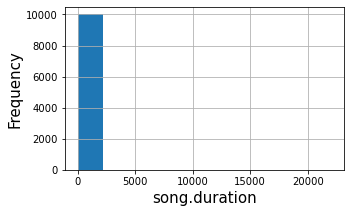

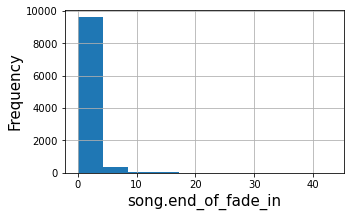

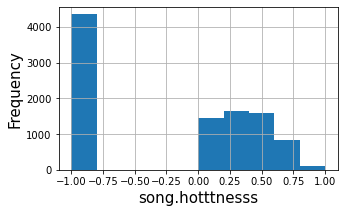

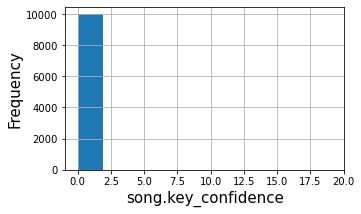

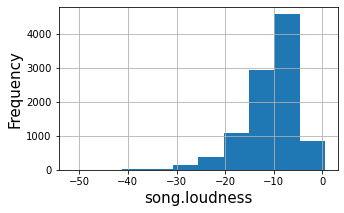

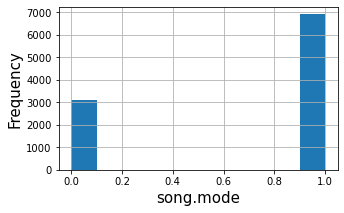

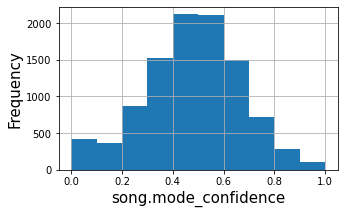

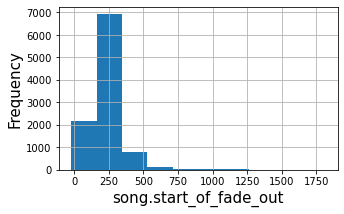

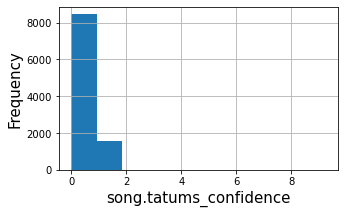

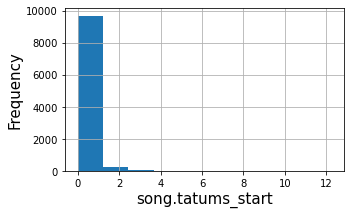

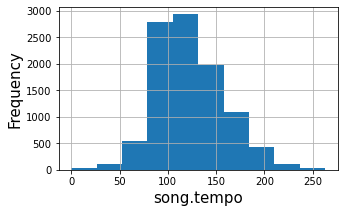

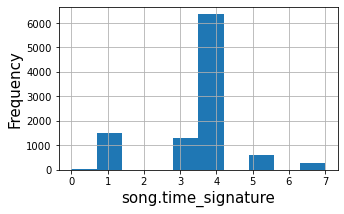

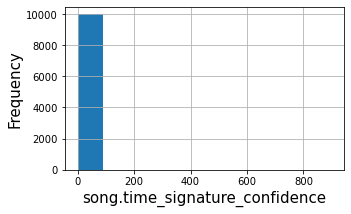

In [13]:
for i in vars_keep:
    hist_plot(df_data, i)

### Question 1.2: Train a Random Forest Classifier with 100 estimators considering these variables:
* vars_keep = ['song.bars_confidence', 'song.bars_start', 'song.beats_confidence', 'song.beats_start', 'song.duration', 'song.end_of_fade_in', 'song.hotttnesss', 'song.key_confidence', 'song.loudness', 'song.mode', 'song.mode_confidence', 'song.start_of_fade_out', 'song.tatums_confidence', 'song.tatums_start', 'song.tempo', 'song.time_signature', 'song.time_signature_confidence']


In [14]:
X = df_data[vars_keep]
y = df_data['class']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print('Training set size - X_train: {} '.format(X_train.shape))
print('Training set size - X_test: {} '.format(X_test.shape))

Training set size - X_train: (8000, 17) 
Training set size - X_test: (2000, 17) 


In [15]:
#RandomForestClassifier n_estimates =100, oob_score = True, random_state = 123456
rf = RandomForestClassifier(n_estimators = 100, oob_score = True, random_state = 123456)
rf.fit(X_train, Y_train)

RandomForestClassifier(oob_score=True, random_state=123456)

In [16]:
def performance_values(X_test, y_test, trained_model):
    
    from sklearn import preprocessing, metrics
    from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
    
    y_pred = trained_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    probs = trained_model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.roc_auc_score(y_test, preds)
    return (fpr, tpr, accuracy, roc_auc)

In [17]:
def ROC_curve(fpr,tpr,roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [18]:
fpr, tpr, rf_acc, rf_roc_auc = performance_values(X_test, Y_test, rf)
print("Accuracy: {}".format(rf_acc))
print("AUC: {}".format(rf_roc_auc))

Accuracy: 0.956
AUC: 0.720316527569984


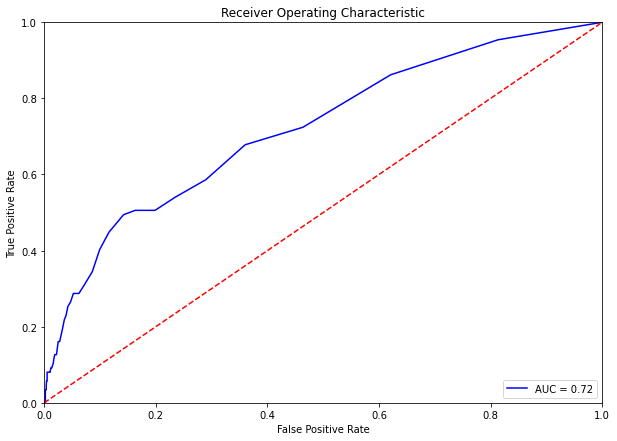

In [19]:
ROC_curve(fpr,tpr,rf_roc_auc)

### Question 2.1: Initializing the LIME explainer. You need to include the following conditions - feature_names, class_names, verbose, discretize_continuous, and mode. It is important to note that when you tune class_name that the order is important.

In [20]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, 
                                                   feature_names = vars_keep, 
                                                   class_names = [0,1],
                                                   verbose = True,
                                                   mode = "classification",
                                                   discretize_continuous=False)

For this assignment, you need to visit the [documentation](https://github.com/marcotcr/lime) for `LIME` and find out how you can pass an instance to get a local explanation and produce some visualizations. Since we are using `LimeTabularExplainer`, you can focus on that in the documentation (example notebooks are provided).

### Question 2.2: Choose an instance from the test data, and obtain explanations for it. The explanations should include no more than 5 features (the top 5).

In [21]:
instance_num = np.random.randint(0, X_test.shape[0])

local_exp = explainer.explain_instance(X_test.iloc[instance_num], rf.predict_proba, num_features = 5)

Intercept 0.15237725479697264
Prediction_local [0.22457867]
Right: 0.03


### Question 2.3: Produce a feature importance plot for the explanation. HINT: `LIME` has a method for this. You only need to call it. <span style="color:red" float:right>; # you need the semi-colon otherwise two dublicate plots are produced</span>

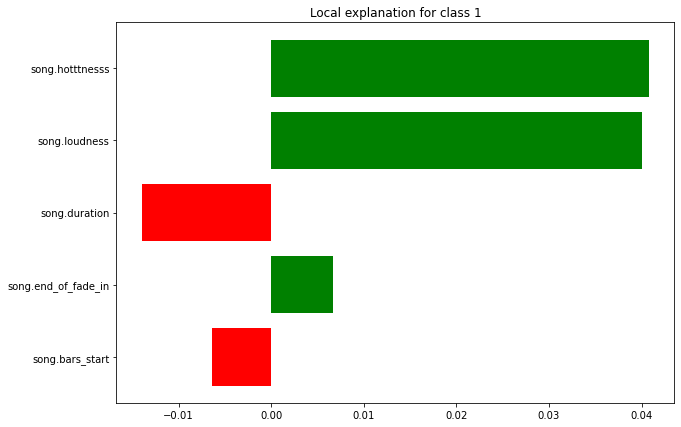

In [22]:
fig = local_exp.as_pyplot_figure()

In [23]:
#Show local_exp data frame as a list
local_exp.as_list()

[('song.hotttnesss', 0.040813260883802854),
 ('song.loudness', 0.040004605600105186),
 ('song.duration', -0.01399065542070793),
 ('song.end_of_fade_in', 0.006711180612305943),
 ('song.bars_start', -0.006381704287927066)]

### Quesiont 3: Call the `show_in_notebook` method to show a summary of the explanation. Set show_table = True, show_all = True

In [24]:
local_exp.show_in_notebook(show_table=True, show_all=False)

Looking at all the contributors not only the top 5.

In [25]:
local_exp.show_in_notebook(show_table=True, show_all=True)

### Question 4: Interpret the results shown by calling `show_in_notebook`. Confirm that the predicted probability shown on the left matches the predicted probability we get by calling the model directly on the instance.

These are the input values for this particular entry:

In [26]:
X_test.iloc[instance_num]

song.bars_confidence                0.010000
song.bars_start                     0.562490
song.beats_confidence               0.985000
song.beats_start                    0.068750
song.duration                     221.413420
song.end_of_fade_in                 0.510000
song.hotttnesss                     0.585453
song.key_confidence                 0.915000
song.loudness                      -7.603000
song.mode                           1.000000
song.mode_confidence                0.737000
song.start_of_fade_out            210.750000
song.tatums_confidence              0.992000
song.tatums_start                   0.068750
song.tempo                        122.002000
song.time_signature                 4.000000
song.time_signature_confidence      0.909000
Name: 8243, dtype: float64

In [27]:
print('The probability of each class by the RF model: {}'.format(rf.predict_proba(X_test)[instance_num]))
print('The prediction from RF model is: {}'.format(rf.predict(X_test)[instance_num]))

The probability of each class by the RF model: [0.97 0.03]
The prediction from RF model is: 0


As we can see the probabilities for both classes are the same as the ones we saw from the LIME plots above.

### [Bonus] Question 5: Repeat the above steps with a Support Vector Machine Classifier. What conclusions to you draw about model explainablity.

In [28]:
svm = SVC(kernel = 'rbf', probability=True)
svm.fit(X_train, Y_train)

SVC(probability=True)

In [29]:
fpr, tpr, svm_acc, svm_roc_auc = performance_values(X_test, Y_test, svm)
print("Accuracy: {}".format(svm_acc))

Accuracy: 0.9565


#### LIME 

In [30]:
explainer_svm = lime.lime_tabular.LimeTabularExplainer(X_train, 
                                                   feature_names = vars_keep, 
                                                   class_names = [0,1],
                                                   verbose = True,
                                                   mode = "classification",
                                                   discretize_continuous=False)

In [31]:
local_exp_svm = explainer_svm.explain_instance(X_test.iloc[instance_num], svm.predict_proba, num_features = 5)

Intercept 0.03245677100403783
Prediction_local [0.03296918]
Right: 0.039879822937811275


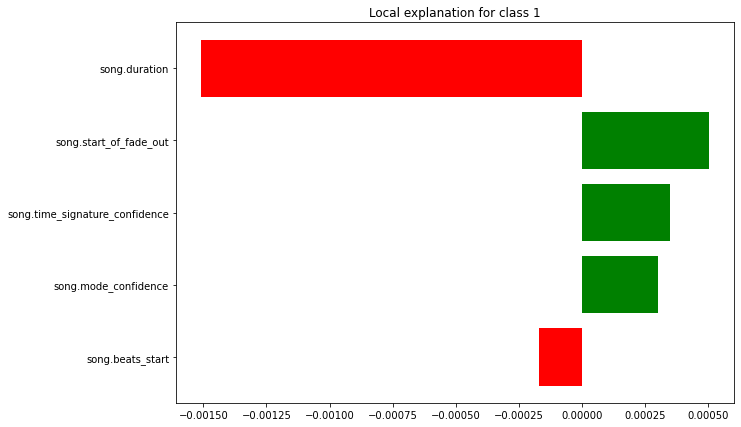

In [32]:
fig_svm = local_exp_svm.as_pyplot_figure()

In [33]:
local_exp_svm.as_list()

[('song.duration', -0.0015077738991854184),
 ('song.start_of_fade_out', 0.0005033932217966061),
 ('song.time_signature_confidence', 0.0003507381183212551),
 ('song.mode_confidence', 0.00030202470129841444),
 ('song.beats_start', -0.0001711955037475736)]

In [34]:
local_exp_svm.show_in_notebook(show_table=True, show_all=False)

In [35]:
print('The probability of each class by the SVM model: {}'.format(svm.predict_proba(X_test)[instance_num]))
print('The prediction from SVM model is: {}'.format(svm.predict(X_test)[instance_num]))

The probability of each class by the SVM model: [0.96012018 0.03987982]
The prediction from SVM model is: 0


### Conclusions from this comparison:



### Question 6: Create a new text cell in your Notebook: Complete a 50-100 word summary (or short description of your thinking in applying this week's learning to the solution) of your experience in this assignment.

As discussed in class the topic of Explainability & Interpretability are taking more and more importance as we see the use & impact of Machine Learning more and more in our daily life. In my experience working with thermodynamic data of commercial engines to create Machine Learning Models to predict behavior and/or potential safety issues (such as engine failures) it was always preferred a simpler model that offer better Explainability & Interpretability, even if that meant lower performance values. This because having a clear understanding of the variables at play and how they interact with each other to produce the final prediction was more important that the prediction itself, especially since almost all the issues were related to safety.

This assignment was really interesting as I have never worked with LIME to help to explain a complex model that otherwise would be very difficult (if not impossible) to clearly explain the reason on why the model is predicting a particular result. As we could see LIME helps providing local model interpretability, which an amazing feature when working with black box models and we need to be able to undertand why certain prediction/decision was made not only at dataset level, but also at the datapoint level. 

Some of the reasons on why we need Explainability & Interpretability in our Machine Learning model are:

- **Problem Context:** In most problems, you are working with a dataset that is only a rough representation of the problem you are trying to solve and a machine learning model can typically not capture the full complexity of the real-life task. An interpretable model helps you to understand and account for the factors that are (not) included in the model and account for the context of the problem when taking actions based on model predictions.


- **Better generalization:** A high interpretability typically leads to a model that generalises better. Interpretability is not about understanding every single detail of the model for all of the data points. The combination of solid data, model and problem understanding is necessary to have a solution that performs better.


- **Ethical and legal consecuences:** In industries like finance and healthcare it is essential to audit the decision process and ensure it is e.g. not discriminatory or violating any laws. With the rise of data and privacy protection regulation like GDPR, interpretability becomes even more essential. In addition, in medical applications or self-driving cars, a single incorrect prediction can have a significant impact and being able to ‘verify’ the model is critical. Therefore the system should be able to explain how it reached a given recommendation.